In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize()

In [2]:
# Define the area of interest (AOI) - Groton, MA
AOI = ee.Geometry.Point([-71.5582, 42.6112])  # Approximate coordinates of Groton, MA

# Filter dataset for the AOI and time range
start_date = '2012-01-01'
end_date = '2025-01-01'

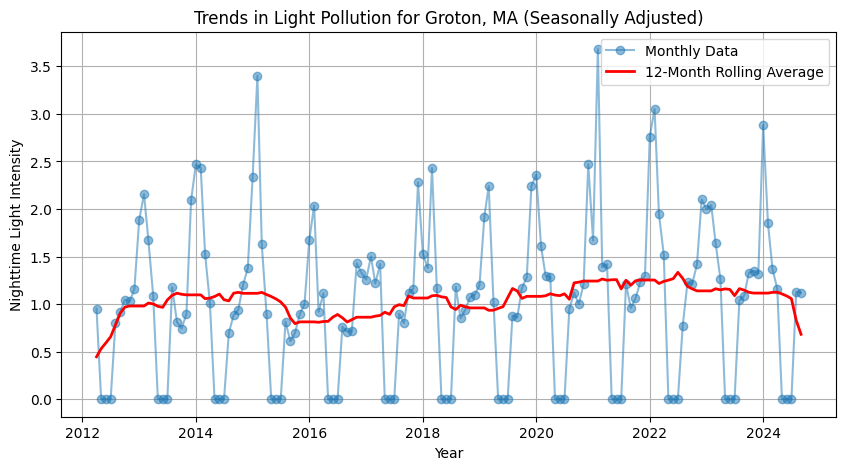

In [3]:
# Load VIIRS Nighttime Lights dataset
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

viirs_filtered = viirs.filterBounds(AOI).filterDate(start_date, end_date)

# Function to extract mean nighttime light values over AOI
def extract_light(image):
    mean_light = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=AOI,
        scale=500,
        bestEffort=True
    )
    return ee.Feature(None, {
        'date': image.date().format(),
        'light_intensity': mean_light.get('avg_rad')
    })

# Apply extraction to each image in collection
light_data = viirs_filtered.map(extract_light).getInfo()

# Convert results to Pandas DataFrame
dates = [feature['properties']['date'] for feature in light_data['features']]
intensities = [feature['properties']['light_intensity'] for feature in light_data['features']]

df = pd.DataFrame({'date': pd.to_datetime(dates), 'light_intensity': intensities})
df.set_index('date', inplace=True)

# Ensure 'light_intensity' is a numeric type
df['light_intensity'] = pd.to_numeric(df['light_intensity'], errors='coerce')

# Drop NaN values
df = df.dropna()

# Compute a 12-month rolling average to adjust for seasonal trends
df['rolling_avg'] = df['light_intensity'].rolling(window=12, center=True, min_periods=1).mean()

# Convert index to numpy array explicitly
dates = df.index.to_numpy()

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(dates, df['light_intensity'].to_numpy(), marker='o', linestyle='-', alpha=0.5, label='Monthly Data')
plt.plot(dates, df['rolling_avg'].to_numpy(), color='red', linewidth=2, label='12-Month Rolling Average')
plt.xlabel('Year')
plt.ylabel('Nighttime Light Intensity')
plt.title('Trends in Light Pollution for Groton, MA (Seasonally Adjusted)')
plt.legend()
plt.grid()
plt.show()

# Analyzing Nighttime Light Intensity Trends in Groton, MA

## Overview
This analysis uses the **VIIRS Nighttime Lights** dataset from the **NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG** collection to examine trends in artificial light intensity over Groton, MA. The dataset provides monthly composites of nighttime lights detected by the **Visible Infrared Imaging Radiometer Suite (VIIRS)**, a satellite-based sensor.

## Methodology
1. **Filtering the Dataset**  
   - The dataset is filtered to include only images covering the specified **Area of Interest (AOI)** (Groton, MA).  
   - A date range is applied to select only relevant months.

2. **Extracting Nighttime Light Intensity**  
   - The **mean radiance** value (`avg_rad`) is computed over the AOI for each monthly image.  
   - The extracted values are stored in a Pandas **DataFrame** for further analysis.

3. **Data Processing**  
   - Non-numeric values are coerced and missing values (`NaN`) are dropped.  
   - A **12-month rolling average** is calculated to smooth out seasonal variations and highlight long-term trends.

4. **Visualization**  
   - The **raw monthly data** is plotted with individual points connected by a line.  
   - The **12-month rolling average** is overlaid in red to show the general trend of nighttime light intensity over time.

## Interpretation
- The **monthly data** (blue line with markers) exhibits fluctuations due to seasonal effects and variability in sensor readings.  
- The **rolling average** (red line) helps to smooth out these fluctuations and reveals broader trends in light pollution over time.  
- Increasing nighttime light intensity could indicate urban expansion, increased commercial activity, or infrastructural developments.  
- Decreasing trends may suggest conservation efforts, population decline, or changes in lighting policies.


---


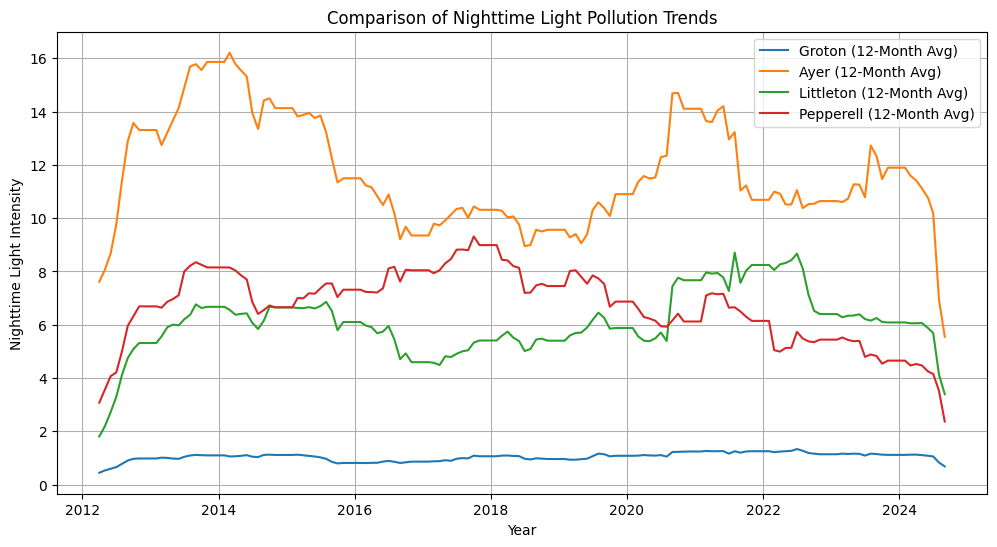

In [4]:
# Define AOIs for Groton and nearby towns
locations = {
    'Groton': ee.Geometry.Point([-71.5582, 42.6112]),
    'Ayer': ee.Geometry.Point([-71.5892, 42.5612]),
    'Littleton': ee.Geometry.Point([-71.5123, 42.5371]),
    'Pepperell': ee.Geometry.Point([-71.5881, 42.6654])
}

# Load VIIRS Nighttime Lights dataset
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

# Filter dataset for the time range
start_date = '2012-01-01'
end_date = '2025-01-01'
viirs_filtered = viirs.filterDate(start_date, end_date)

# Function to extract mean nighttime light values over AOI
def extract_light(image, AOI):
    mean_light = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=AOI,
        scale=500,
        bestEffort=True
    )
    return ee.Feature(None, {
        'date': image.date().format(),
        'light_intensity': mean_light.get('avg_rad')
    })

# Function to process nighttime lights data for a given town
def get_light_data(location_name, AOI):
    light_data = viirs_filtered.filterBounds(AOI).map(lambda img: extract_light(img, AOI)).getInfo()
    
    dates = [feature['properties']['date'] for feature in light_data['features']]
    intensities = [feature['properties']['light_intensity'] for feature in light_data['features']]
    
    df = pd.DataFrame({'date': pd.to_datetime(dates), 'light_intensity': intensities})
    df.set_index('date', inplace=True)
    df['light_intensity'] = pd.to_numeric(df['light_intensity'], errors='coerce')
    df = df.dropna()
    df['rolling_avg'] = df['light_intensity'].rolling(window=12, center=True, min_periods=1).mean()
    
    return df

# Retrieve data for all locations
town_data = {town: get_light_data(town, AOI) for town, AOI in locations.items()}

# Plot comparison of nighttime light pollution trends
plt.figure(figsize=(12, 6))
for town, df in town_data.items():
    plt.plot(df.index.to_numpy(), df['rolling_avg'].to_numpy(), label=f'{town} (12-Month Avg)')

plt.xlabel('Year')
plt.ylabel('Nighttime Light Intensity')
plt.title('Comparison of Nighttime Light Pollution Trends')
plt.legend()
plt.grid()
plt.show()

# Comparative Analysis of Nighttime Light Pollution in Groton and Nearby Towns

## Overview
This analysis examines trends in nighttime light intensity across **Groton, Ayer, Littleton, and Pepperell, MA** using data from the **VIIRS Nighttime Lights** dataset. The goal is to compare artificial illumination levels over time and assess regional variations in light pollution.

## Methodology
1. **Defining Areas of Interest (AOIs)**  
   - Geographic points are specified for each town to serve as AOIs for analysis.

2. **Loading and Filtering the VIIRS Dataset**  
   - The **NOAA VIIRS/DNB/MONTHLY_V1/VCMCFG** dataset is used.  
   - The dataset is filtered for the time range **January 2012 - January 2025**.

3. **Extracting Nighttime Light Intensity**  
   - The mean radiance (`avg_rad`) is calculated over each AOI for every monthly image.  
   - Extracted values are stored in a Pandas **DataFrame** for further analysis.

4. **Data Processing**  
   - Non-numeric values are coerced and missing values (`NaN`) are dropped.  
   - A **12-month rolling average** is computed to smooth out seasonal variations.

5. **Visualization**  
   - A **comparative line plot** is generated to display trends for each town, focusing on the rolling average of nighttime light intensity.

## Interpretation
- Each town exhibits **distinct trends** in light pollution, which may be influenced by factors such as:
  - Urban expansion and population growth.
  - Infrastructure development and commercial activity.
  - Conservation efforts and changes in public lighting policies.
- Towns with a **steadily increasing trend** may be experiencing urbanization, while towns with **stabilized or declining trends** may have implemented effective light pollution control measures.

---


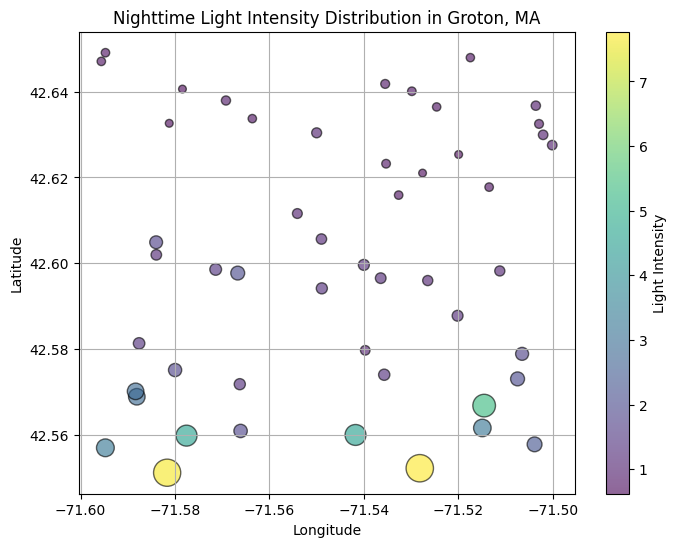

In [5]:
# Load VIIRS Nighttime Lights dataset
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

# Select the most recent available image
latest_image = viirs.filterBounds(AOI).sort('system:time_start', False).first()

# Generate a grid of points within the AOI
num_points = 50
points = [ee.Geometry.Point([np.random.uniform(-71.6, -71.5), np.random.uniform(42.55, 42.65)]) for _ in range(num_points)]
features = [ee.Feature(pt) for pt in points]
feature_collection = ee.FeatureCollection(features)

# Function to extract nighttime light intensity at each point
def extract_light_intensity(feature):
    mean_light = latest_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=500,
        bestEffort=True
    )
    return feature.set({'light_intensity': mean_light.get('avg_rad')})

# Apply extraction
sampled_data = feature_collection.map(extract_light_intensity).getInfo()

# Convert results to Pandas DataFrame
longitudes = [f['geometry']['coordinates'][0] for f in sampled_data['features']]
latitudes = [f['geometry']['coordinates'][1] for f in sampled_data['features']]
intensities = [f['properties']['light_intensity'] for f in sampled_data['features']]

df = pd.DataFrame({'longitude': longitudes, 'latitude': latitudes, 'light_intensity': intensities})

# Ensure 'light_intensity' is numeric
df['light_intensity'] = pd.to_numeric(df['light_intensity'], errors='coerce')

# Drop NaN values
df = df.dropna()

# Plot bubble chart
plt.figure(figsize=(8, 6))
sc = plt.scatter(df['longitude'], df['latitude'], s=df['light_intensity'] * 50, c=df['light_intensity'], cmap='viridis', alpha=0.6, edgecolors='k')
plt.colorbar(sc, label='Light Intensity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Nighttime Light Intensity Distribution in Groton, MA')
plt.grid()
plt.show()

# Spatial Distribution of Nighttime Light Intensity in Groton, MA

## Overview
This analysis examines the **spatial variation of nighttime light intensity** in **Groton, MA** using the latest available VIIRS Nighttime Lights data. The study employs a grid-based sampling approach to measure light intensity at multiple locations within the **Area of Interest (AOI)**.

## Methodology
1. **Loading VIIRS Nighttime Lights Data**  
   - The **NOAA VIIRS/DNB/MONTHLY_V1/VCMCFG** dataset is used.  
   - The most **recently available image** is selected for analysis.

2. **Generating a Grid of Sample Points**  
   - A **randomized grid of 50 points** is generated within the AOI.  
   - Each point represents a location where nighttime light intensity will be measured.

3. **Extracting Nighttime Light Intensity**  
   - The **mean radiance (`avg_rad`)** is extracted at each grid point using **a 500-meter scale**.  
   - The extracted data is stored in a **Pandas DataFrame** for analysis.

4. **Data Processing**  
   - Non-numeric values are coerced and missing values (`NaN`) are removed.

5. **Visualization**  
   - A **bubble chart** is created to **map the spatial distribution** of nighttime light intensity.  
   - Each point’s **size and color** represent the **measured light intensity**.
   - A **color bar** is included to indicate intensity levels.

## Interpretation
- **Brighter areas** indicate regions with higher artificial illumination, likely corresponding to:
  - **Commercial zones, industrial areas, or major roads.**  
- **Darker areas** suggest minimal artificial lighting, which may correspond to:
  - **Residential neighborhoods, conservation areas, or less-developed land.**  
- The **spatial variability** of nighttime lights can provide insights into **urban planning, energy consumption, and environmental impact**.


---


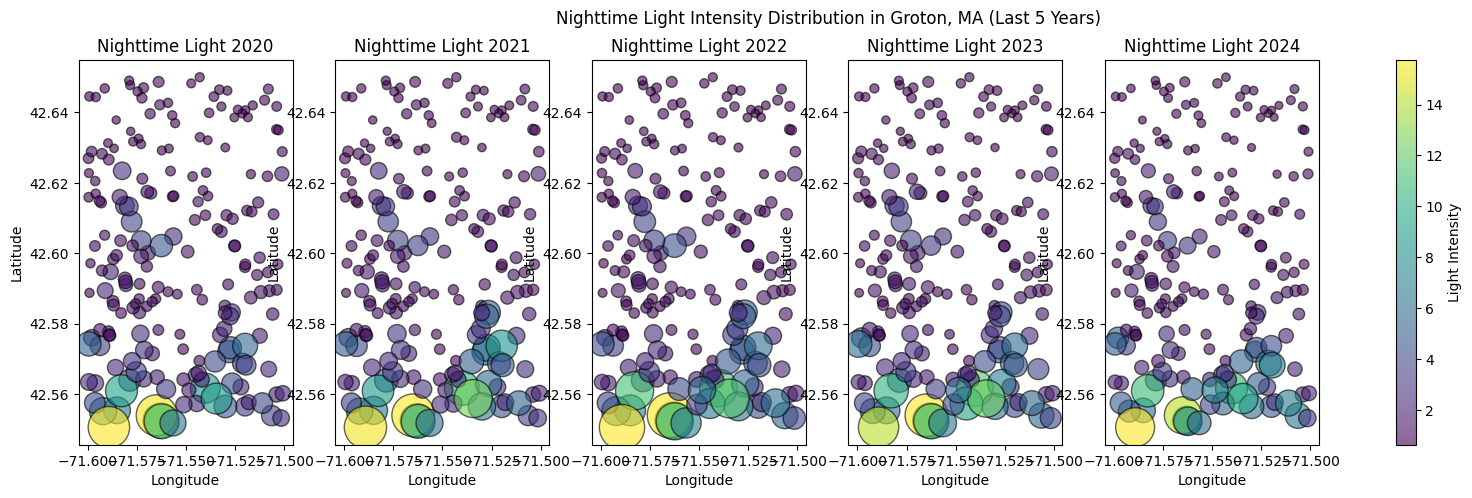

In [12]:
# Load VIIRS Nighttime Lights dataset
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

# Generate a grid of points within the AOI
num_points = 200
points = [ee.Geometry.Point([np.random.uniform(-71.6, -71.5), np.random.uniform(42.55, 42.65)]) for _ in range(num_points)]
features = [ee.Feature(pt) for pt in points]
feature_collection = ee.FeatureCollection(features)

# Function to extract nighttime light intensity at each point for a given year
def extract_light_intensity(image):
    def map_feature(feature):
        mean_light = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=500,
            bestEffort=True
        )
        return feature.set({'light_intensity': mean_light.get('avg_rad')})
    
    return feature_collection.map(map_feature)

# Loop through last 5 years
years = list(range(2020, 2025))
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, year in enumerate(years):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    
    # Select annual median image
    yearly_image = viirs.filterBounds(AOI).filterDate(start_date, end_date).median()
    
    # Extract light intensity for sampled points
    sampled_data = extract_light_intensity(yearly_image).getInfo()
    
    # Convert results to Pandas DataFrame
    longitudes = [f['geometry']['coordinates'][0] for f in sampled_data['features']]
    latitudes = [f['geometry']['coordinates'][1] for f in sampled_data['features']]
    intensities = [f['properties']['light_intensity'] for f in sampled_data['features']]

    df = pd.DataFrame({'longitude': longitudes, 'latitude': latitudes, 'light_intensity': intensities})

    # Ensure 'light_intensity' is numeric
    df['light_intensity'] = pd.to_numeric(df['light_intensity'], errors='coerce')

    # Drop NaN values
    df = df.dropna()

    # Plot bubble chart
    sc = axes[i].scatter(df['longitude'], df['latitude'], s=df['light_intensity'] * 50, c=df['light_intensity'], cmap='viridis', alpha=0.6, edgecolors='k')
    axes[i].set_title(f'Nighttime Light {year}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')

# Add colorbar
fig.colorbar(sc, ax=axes, orientation='vertical', label='Light Intensity')

plt.suptitle('Nighttime Light Intensity Distribution in Groton, MA (Last 5 Years)')
plt.show()

# Temporal Analysis of Nighttime Light Intensity in Groton, MA (Last 5 Years)

## Overview
This analysis examines **how nighttime light intensity has changed over the past five years (2020-2024)** in **Groton, MA**. The goal is to visualize annual trends and spatial patterns in artificial illumination.

## Methodology
1. **Loading VIIRS Nighttime Lights Data**  
   - The **NOAA VIIRS/DNB/MONTHLY_V1/VCMCFG** dataset is used.

2. **Generating a Grid of Sample Points**  
   - A **randomized grid of 200 points** is created within the **Area of Interest (AOI)**.
   - These points serve as sampling locations for nighttime light intensity measurements.

3. **Extracting Annual Nighttime Light Intensity**  
   - For each year (2020-2024):
     - The **annual median image** is computed from the VIIRS dataset.
     - The **mean radiance (`avg_rad`)** is extracted at each sample point.
     - The data is stored in a **Pandas DataFrame** for further analysis.

4. **Visualization**  
   - A **bubble chart** is plotted for each year, showing the spatial distribution of nighttime light intensity.
   - **Larger and darker bubbles** indicate areas with **higher light intensity**.
   - A **color bar** is included to indicate relative light intensity levels.

## Interpretation
- **Changes in nighttime light distribution over time** may indicate:
  - **Urban expansion and increased infrastructure development.**  
  - **Changes in lighting regulations or conservation efforts.**  
  - **Variability in seasonal or atmospheric conditions affecting satellite detection.**  
- **Spatial hotspots of high intensity** may correspond to **commercial zones, roads, or industrial areas**.

---


In [15]:
# Define Area of Interest (AOI)
AOI = ee.Geometry.Rectangle([-71.6, 42.55, -71.5, 42.65])  # Approximate bounding box of Groton, MA

# Load VIIRS Nighttime Lights Data
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('avg_rad')

# Filter data for a specific timeframe (e.g., the last 12 months)
viirs_filtered = viirs.filterDate('2023-01-01', '2023-12-31')

# Identify high-intensity regions
def identify_high_intensity_regions(image):
  threshold = 30  # Define intensity threshold
  high_intensity = image.gt(threshold).selfMask()  # Mask out low-intensity areas
  return high_intensity

high_intensity_areas = viirs_filtered.map(identify_high_intensity_regions)

# Create a map
Map = geemap.Map()
Map.centerObject(AOI, 12)

# **1. Add High-Intensity Areas First (Transparent)**
Map.addLayer(
  high_intensity_areas.median(),
  {'min': 30, 'max': 60, 'palette': ['red', 'yellow'], 'opacity': 0.5},  # Increased transparency
  'High Intensity Areas (Transparent)'
)

# **2. Overlay the full VIIRS dataset**
Map.addLayer(
  viirs_filtered.median(), 
  {'bands': ['avg_rad'], 'min': 0, 'max': 60, 'palette': ['black', 'blue', 'purple', 'red', 'orange', 'yellow']}, 
  'VIIRS Median'
)

Map.add_basemap('Esri.WorldTopoMap', opacity=0.5)  # Lower opacity

# Display the map
Map


Map(center=[42.59999749575994, -71.54999999999909], controls=(WidgetControl(options=['position', 'transparent_…

# Mapping High-Intensity Nighttime Light Areas in Groton, MA (2023)

## Overview
This analysis maps regions with **high nighttime light intensity** in **Groton, MA** for the year **2023** using VIIRS Nighttime Lights data. The goal is to identify areas with significant artificial illumination and visualize their distribution.

## Methodology
1. **Defining the Area of Interest (AOI)**  
   - A bounding box is created to cover **Groton, MA**.

2. **Loading VIIRS Nighttime Lights Data**  
   - The **NOAA VIIRS/DNB/MONTHLY_V1/VCMSLCFG** dataset is used.  
   - The **`avg_rad`** band, representing radiance values, is selected.  
   - The dataset is filtered to **only include images from 2023**.

3. **Identifying High-Intensity Regions**  
   - A threshold of **30 radiance units** is applied to mask out low-intensity areas.  
   - Only pixels **above this threshold** are retained, highlighting the most illuminated regions.

4. **Visualization**
   - A **layer of high-intensity areas** is added to the map with **semi-transparency** (`opacity: 0.5`).  
   - The **median nighttime lights** from VIIRS for 2023 is overlaid with a **color gradient**, showing **overall light distribution**.  
   - A **topographic basemap** is added with reduced opacity for geographical context.

## Interpretation
- **Bright red and yellow areas** in the high-intensity layer correspond to locations with **the highest levels of artificial lighting**, which may include:
  - **Commercial centers, industrial areas, and major roadways.**  
  - **Dense residential neighborhoods with strong lighting.**  
- The **darker regions** indicate areas with minimal artificial illumination, likely **forested lands, conservation areas, or less developed zones**.

---


In [16]:
# Define Area of Interest (AOI)
AOI = ee.Geometry.Rectangle([-71.6, 42.55, -71.5, 42.65])  # Approximate bounding box of Groton, MA

# Load VIIRS Nighttime Lights Data
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('avg_rad')

# Filter data for the desired timeframe
viirs_filtered = viirs.filterDate('2023-01-01', '2023-12-31')

# Compute statistics within AOI
viirs_median = viirs_filtered.median().clip(AOI)
viirs_stats = viirs_median.reduceRegion(
  reducer=ee.Reducer.percentile([5, 95]),
  geometry=AOI,
  scale=500,
  bestEffort=True
)

p5 = viirs_stats.getNumber('avg_rad_p5')
p95 = viirs_stats.getNumber('avg_rad_p95')

# Normalize brightness relative to AOI
def normalize_intensity(image):
  return image.subtract(p5).divide(p95.subtract(p5)).clamp(0, 1)

relative_intensity = viirs_filtered.map(normalize_intensity)

# Create a map
Map = geemap.Map()
Map.centerObject(AOI, 12)

# Add the relative intensity layer
Map.addLayer(
  relative_intensity.median(),
  {'min': 0, 'max': 1, 'palette': ['black', 'blue', 'purple', 'red', 'orange', 'yellow']}, 
  'Relative Intensity (Normalized to Groton)'
)

Map.add_basemap('Esri.WorldTopoMap', opacity=0.5)  # Lower opacity

# Display the map
Map


Map(center=[42.59999749575994, -71.54999999999909], controls=(WidgetControl(options=['position', 'transparent_…

# Normalized Nighttime Light Intensity in Groton, MA (2023)

## Overview
This analysis presents a **normalized nighttime light intensity map** for **Groton, MA**, using **VIIRS Nighttime Lights** data for the year **2023**. The goal is to **standardize brightness levels** relative to the study area, allowing for better comparison of artificial illumination within the region.

## Methodology
1. **Defining the Area of Interest (AOI)**  
   - A bounding box is set around **Groton, MA** to limit the analysis area.

2. **Loading VIIRS Nighttime Lights Data**  
   - The **NOAA VIIRS/DNB/MONTHLY_V1/VCMSLCFG** dataset is used.  
   - The **`avg_rad`** band, representing radiance values, is selected.  
   - The dataset is filtered to include only **data from 2023**.

3. **Computing Regional Statistics**  
   - The **5th percentile (`p5`)** and **95th percentile (`p95`)** of brightness values within the AOI are computed.  
   - These percentiles help establish a **local brightness range** for normalization.

4. **Normalizing Light Intensity**  
   - Each pixel’s brightness is **scaled between 0 and 1** using the formula:  
     \[
     \text{normalized value} = \frac{\text{pixel value} - p5}{p95 - p5}
     \]
   - Values are **clamped between 0 and 1** to ensure a consistent range.

5. **Visualization**  
   - A **colorized map** is generated, where:
     - **Black** represents the lowest relative intensity.  
     - **Blue to yellow** represents increasing brightness levels.  
   - A **topographic basemap** is overlaid for geographical context.

## Interpretation
- **Normalized intensity values** allow for better differentiation between **brighter urban areas** and **darker natural landscapes** within **Groton, MA**.
- **Higher-intensity regions** (red, orange, yellow) may correspond to **commercial zones, roads, or dense residential neighborhoods**.
- **Lower-intensity areas** (blue, black) likely represent **forests, open spaces, or conservation land**.

---
